# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

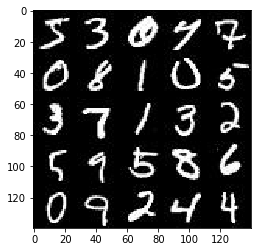

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

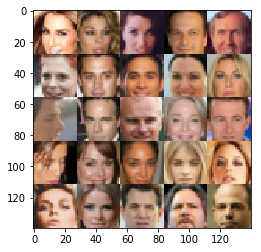

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),'inputs_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),'inputs_zdim')
    learn_rate=tf.placeholder(tf.float32)
    return (inputs_real,inputs_z,learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.001
    with tf.variable_scope("discriminator",reuse=reuse):
        #image is now 14x14x64
        conv1=tf.layers.conv2d(images,64,5,strides=2,padding='SAME')
        relu1=tf.maximum(conv1*alpha,conv1)
        #7x7x128
        conv2=tf.layers.conv2d(relu1,128,5,strides=2,padding='SAME')
        bn2=tf.layers.batch_normalization(conv2,training=True)
        relu2=tf.maximum(bn2*alpha,bn2)
        #4x4x256
        conv3=tf.layers.conv2d(relu2, 256, 5, strides=2,padding='SAME')
        bn3=tf.layers.batch_normalization(conv3,training=True)
        relu3=tf.maximum(bn3*alpha,bn3)
        
        relu3shape=relu3.get_shape().as_list()
        fullyconnected=tf.reshape(relu3,(-1,relu3shape[1]*relu3shape[2]*relu3shape[3]))
        logits=tf.layers.dense(fullyconnected,1)
        out=tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.001
    
    if is_train==True:
        reuse=False
    else:
        reuse=True
    
    with tf.variable_scope("generator",reuse=reuse):
        fully_connected1=tf.layers.dense(z,7*7*256)
        
        # 7x7x256
        reshape1=tf.reshape(fully_connected1,(-1,7,7,256))
        bn1=tf.layers.batch_normalization(reshape1,training=is_train)
        relu1=tf.maximum(alpha*bn1,bn1)
        # 14x14x128
        conv2=tf.layers.conv2d_transpose(relu1,128,5,strides=2,padding='SAME')
        bn2=tf.layers.batch_normalization(conv2,training=is_train)
        relu2=tf.maximum(alpha*bn2,bn2)
        
        #output is 28x28xout_channel_dim
        logits=tf.layers.conv2d_transpose(relu2,out_channel_dim,5,strides=2,padding='SAME')
        output=tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    fakeimages=generator(input_z,out_channel_dim=out_channel_dim)
    
    output_real,logits_real=discriminator(input_real)
    output_fake,logits_fake=discriminator(fakeimages,reuse=True)
    
    d_loss_real=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real)))
    d_loss_fake=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_fake)))
    g_loss=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))
    d_loss=d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables=tf.trainable_variables()
    d_vars=[var for var in variables if var.name[:3]=='dis']
    g_vars=[var for var in variables if var.name[:3]=='gen']
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt=tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
        return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real,inputs_z,learn_rate=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt,g_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps=0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run((g_opt,d_opt),feed_dict={inputs_real:batch_images,inputs_z:batch_z})
#                 sess.run(d_opt,feed_dict={inputs_real:batch_images,inputs_z:batch_z})
                
                
                disc_loss=sess.run(d_loss,feed_dict={inputs_real:batch_images,inputs_z:batch_z})
                gen_loss=sess.run(g_loss,feed_dict={inputs_real:batch_images,inputs_z:batch_z})
                
                if steps%10==0:
                    print("Epoch: ",epoch_i,"Batch: ",steps,"Discriminator_Loss: ",disc_loss,"Generator_Loss: ",gen_loss)
                if steps%100==0:
                    show_generator_output(sess, 30, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch:  0 Batch:  10 Discriminator_Loss:  6.22254 Generator_Loss:  0.0033014
Epoch:  0 Batch:  20 Discriminator_Loss:  9.44627 Generator_Loss:  0.000310753
Epoch:  0 Batch:  30 Discriminator_Loss:  2.38701 Generator_Loss:  17.4056
Epoch:  0 Batch:  40 Discriminator_Loss:  0.0956724 Generator_Loss:  3.3216
Epoch:  0 Batch:  50 Discriminator_Loss:  3.35339 Generator_Loss:  0.0742718
Epoch:  0 Batch:  60 Discriminator_Loss:  2.28186 Generator_Loss:  0.169986
Epoch:  0 Batch:  70 Discriminator_Loss:  2.67533 Generator_Loss:  0.132337
Epoch:  0 Batch:  80 Discriminator_Loss:  2.06442 Generator_Loss:  0.216407
Epoch:  0 Batch:  90 Discriminator_Loss:  1.75686 Generator_Loss:  0.348576
Epoch:  0 Batch:  100 Discriminator_Loss:  1.68154 Generator_Loss:  0.283771


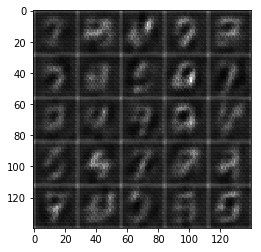

Epoch:  0 Batch:  110 Discriminator_Loss:  2.03121 Generator_Loss:  0.181608
Epoch:  0 Batch:  120 Discriminator_Loss:  2.14477 Generator_Loss:  0.203353
Epoch:  0 Batch:  130 Discriminator_Loss:  1.23799 Generator_Loss:  0.440173
Epoch:  0 Batch:  140 Discriminator_Loss:  0.404954 Generator_Loss:  1.42904
Epoch:  0 Batch:  150 Discriminator_Loss:  1.01344 Generator_Loss:  0.695561
Epoch:  0 Batch:  160 Discriminator_Loss:  0.255256 Generator_Loss:  2.3547
Epoch:  0 Batch:  170 Discriminator_Loss:  0.510624 Generator_Loss:  3.01223
Epoch:  0 Batch:  180 Discriminator_Loss:  0.603957 Generator_Loss:  4.35741
Epoch:  0 Batch:  190 Discriminator_Loss:  0.20256 Generator_Loss:  3.40482
Epoch:  0 Batch:  200 Discriminator_Loss:  0.0366378 Generator_Loss:  5.26771


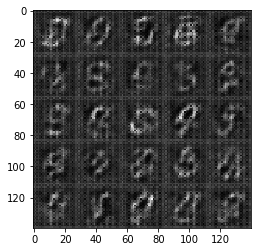

Epoch:  0 Batch:  210 Discriminator_Loss:  0.0169544 Generator_Loss:  7.07327
Epoch:  0 Batch:  220 Discriminator_Loss:  0.0296444 Generator_Loss:  4.37716
Epoch:  0 Batch:  230 Discriminator_Loss:  0.0303833 Generator_Loss:  4.01352
Epoch:  0 Batch:  240 Discriminator_Loss:  0.0211905 Generator_Loss:  4.66037
Epoch:  0 Batch:  250 Discriminator_Loss:  0.00643521 Generator_Loss:  6.76232
Epoch:  0 Batch:  260 Discriminator_Loss:  0.0110111 Generator_Loss:  5.0771
Epoch:  0 Batch:  270 Discriminator_Loss:  0.00352785 Generator_Loss:  7.96415
Epoch:  0 Batch:  280 Discriminator_Loss:  0.0112181 Generator_Loss:  5.30195
Epoch:  0 Batch:  290 Discriminator_Loss:  0.0184271 Generator_Loss:  4.72297
Epoch:  0 Batch:  300 Discriminator_Loss:  0.00607704 Generator_Loss:  5.93339


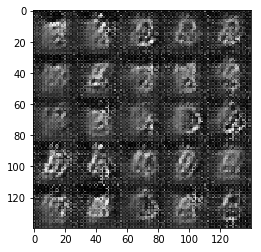

Epoch:  0 Batch:  310 Discriminator_Loss:  1.57827 Generator_Loss:  7.26467
Epoch:  0 Batch:  320 Discriminator_Loss:  1.07488 Generator_Loss:  4.53939
Epoch:  0 Batch:  330 Discriminator_Loss:  0.98389 Generator_Loss:  3.90266
Epoch:  0 Batch:  340 Discriminator_Loss:  0.799264 Generator_Loss:  3.13352
Epoch:  0 Batch:  350 Discriminator_Loss:  0.895675 Generator_Loss:  3.27177
Epoch:  0 Batch:  360 Discriminator_Loss:  1.70027 Generator_Loss:  3.45798
Epoch:  0 Batch:  370 Discriminator_Loss:  1.30436 Generator_Loss:  2.31148
Epoch:  0 Batch:  380 Discriminator_Loss:  1.0074 Generator_Loss:  1.97204
Epoch:  0 Batch:  390 Discriminator_Loss:  1.1586 Generator_Loss:  2.45989
Epoch:  0 Batch:  400 Discriminator_Loss:  0.702716 Generator_Loss:  1.83621


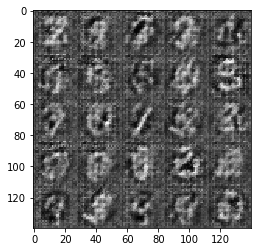

Epoch:  0 Batch:  410 Discriminator_Loss:  0.67492 Generator_Loss:  1.98462
Epoch:  0 Batch:  420 Discriminator_Loss:  0.682064 Generator_Loss:  1.80615
Epoch:  0 Batch:  430 Discriminator_Loss:  0.523083 Generator_Loss:  1.5391
Epoch:  0 Batch:  440 Discriminator_Loss:  3.25707 Generator_Loss:  5.35876
Epoch:  0 Batch:  450 Discriminator_Loss:  0.775561 Generator_Loss:  0.955793
Epoch:  0 Batch:  460 Discriminator_Loss:  0.379075 Generator_Loss:  1.80126
Epoch:  0 Batch:  470 Discriminator_Loss:  0.552784 Generator_Loss:  1.68308
Epoch:  0 Batch:  480 Discriminator_Loss:  1.64232 Generator_Loss:  0.327305
Epoch:  0 Batch:  490 Discriminator_Loss:  0.699454 Generator_Loss:  3.2011
Epoch:  0 Batch:  500 Discriminator_Loss:  0.494435 Generator_Loss:  1.88919


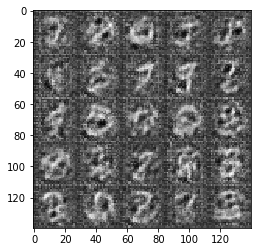

Epoch:  0 Batch:  510 Discriminator_Loss:  0.159589 Generator_Loss:  2.73752
Epoch:  0 Batch:  520 Discriminator_Loss:  1.1146 Generator_Loss:  0.574802
Epoch:  0 Batch:  530 Discriminator_Loss:  0.867635 Generator_Loss:  0.650095
Epoch:  0 Batch:  540 Discriminator_Loss:  0.0900207 Generator_Loss:  4.41025
Epoch:  0 Batch:  550 Discriminator_Loss:  0.0260403 Generator_Loss:  6.36854
Epoch:  0 Batch:  560 Discriminator_Loss:  0.0554097 Generator_Loss:  3.97396
Epoch:  0 Batch:  570 Discriminator_Loss:  0.103735 Generator_Loss:  2.77005
Epoch:  0 Batch:  580 Discriminator_Loss:  0.563072 Generator_Loss:  1.99758
Epoch:  0 Batch:  590 Discriminator_Loss:  0.155005 Generator_Loss:  2.57955
Epoch:  0 Batch:  600 Discriminator_Loss:  0.0824345 Generator_Loss:  3.42965


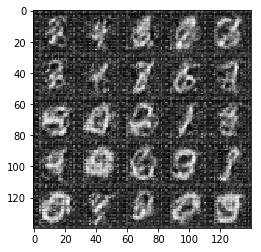

Epoch:  0 Batch:  610 Discriminator_Loss:  0.103155 Generator_Loss:  2.95229
Epoch:  0 Batch:  620 Discriminator_Loss:  0.0209711 Generator_Loss:  6.06941
Epoch:  0 Batch:  630 Discriminator_Loss:  5.69894 Generator_Loss:  6.56548
Epoch:  0 Batch:  640 Discriminator_Loss:  0.121726 Generator_Loss:  4.50088
Epoch:  0 Batch:  650 Discriminator_Loss:  3.94537 Generator_Loss:  7.50352
Epoch:  0 Batch:  660 Discriminator_Loss:  0.130335 Generator_Loss:  3.09356
Epoch:  0 Batch:  670 Discriminator_Loss:  0.055172 Generator_Loss:  5.81292
Epoch:  0 Batch:  680 Discriminator_Loss:  0.166733 Generator_Loss:  2.32489
Epoch:  0 Batch:  690 Discriminator_Loss:  0.10613 Generator_Loss:  3.05991
Epoch:  0 Batch:  700 Discriminator_Loss:  0.0479585 Generator_Loss:  5.11037


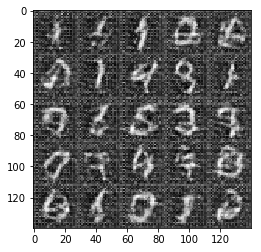

Epoch:  0 Batch:  710 Discriminator_Loss:  0.0395936 Generator_Loss:  4.93343
Epoch:  0 Batch:  720 Discriminator_Loss:  0.0683408 Generator_Loss:  3.28742
Epoch:  0 Batch:  730 Discriminator_Loss:  0.0601311 Generator_Loss:  6.23485
Epoch:  0 Batch:  740 Discriminator_Loss:  0.00715814 Generator_Loss:  7.2088
Epoch:  0 Batch:  750 Discriminator_Loss:  0.0451478 Generator_Loss:  3.73677
Epoch:  0 Batch:  760 Discriminator_Loss:  0.0089691 Generator_Loss:  6.44864
Epoch:  0 Batch:  770 Discriminator_Loss:  0.00764675 Generator_Loss:  7.22345
Epoch:  0 Batch:  780 Discriminator_Loss:  0.126496 Generator_Loss:  2.53028
Epoch:  0 Batch:  790 Discriminator_Loss:  0.0233719 Generator_Loss:  10.2788
Epoch:  0 Batch:  800 Discriminator_Loss:  0.00798256 Generator_Loss:  7.03089


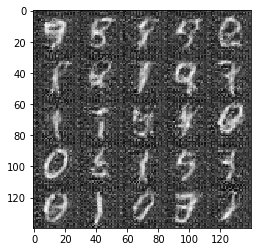

Epoch:  0 Batch:  810 Discriminator_Loss:  2.09064 Generator_Loss:  0.184884
Epoch:  0 Batch:  820 Discriminator_Loss:  0.14646 Generator_Loss:  2.37298
Epoch:  0 Batch:  830 Discriminator_Loss:  0.0257167 Generator_Loss:  5.93779
Epoch:  0 Batch:  840 Discriminator_Loss:  0.0113341 Generator_Loss:  6.05118
Epoch:  0 Batch:  850 Discriminator_Loss:  3.14001 Generator_Loss:  7.44784
Epoch:  0 Batch:  860 Discriminator_Loss:  0.604618 Generator_Loss:  2.44836
Epoch:  0 Batch:  870 Discriminator_Loss:  1.04586 Generator_Loss:  3.61147
Epoch:  0 Batch:  880 Discriminator_Loss:  1.52311 Generator_Loss:  1.18552
Epoch:  0 Batch:  890 Discriminator_Loss:  0.436368 Generator_Loss:  1.39139
Epoch:  0 Batch:  900 Discriminator_Loss:  0.125157 Generator_Loss:  2.68751


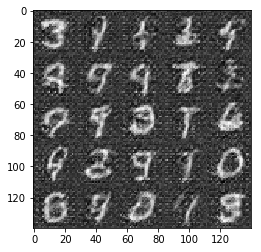

Epoch:  0 Batch:  910 Discriminator_Loss:  0.25559 Generator_Loss:  1.75085
Epoch:  0 Batch:  920 Discriminator_Loss:  0.164731 Generator_Loss:  2.34792
Epoch:  0 Batch:  930 Discriminator_Loss:  0.11295 Generator_Loss:  4.60747
Epoch:  1 Batch:  940 Discriminator_Loss:  0.0321924 Generator_Loss:  4.76918
Epoch:  1 Batch:  950 Discriminator_Loss:  0.0371973 Generator_Loss:  4.18226
Epoch:  1 Batch:  960 Discriminator_Loss:  0.0128563 Generator_Loss:  6.32187
Epoch:  1 Batch:  970 Discriminator_Loss:  0.0163292 Generator_Loss:  5.15577
Epoch:  1 Batch:  980 Discriminator_Loss:  0.436752 Generator_Loss:  1.39032
Epoch:  1 Batch:  990 Discriminator_Loss:  0.0251219 Generator_Loss:  4.68976
Epoch:  1 Batch:  1000 Discriminator_Loss:  0.025646 Generator_Loss:  4.46474


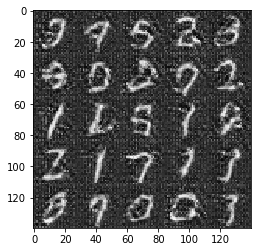

Epoch:  1 Batch:  1010 Discriminator_Loss:  0.00649583 Generator_Loss:  7.00262
Epoch:  1 Batch:  1020 Discriminator_Loss:  0.0093404 Generator_Loss:  5.54697
Epoch:  1 Batch:  1030 Discriminator_Loss:  0.00851281 Generator_Loss:  5.95863
Epoch:  1 Batch:  1040 Discriminator_Loss:  0.0116363 Generator_Loss:  5.22222
Epoch:  1 Batch:  1050 Discriminator_Loss:  0.00546614 Generator_Loss:  7.05196
Epoch:  1 Batch:  1060 Discriminator_Loss:  0.00555938 Generator_Loss:  8.34627
Epoch:  1 Batch:  1070 Discriminator_Loss:  0.0236518 Generator_Loss:  4.35001
Epoch:  1 Batch:  1080 Discriminator_Loss:  0.0160165 Generator_Loss:  8.64831
Epoch:  1 Batch:  1090 Discriminator_Loss:  0.00800889 Generator_Loss:  5.55505
Epoch:  1 Batch:  1100 Discriminator_Loss:  0.0165458 Generator_Loss:  4.99168


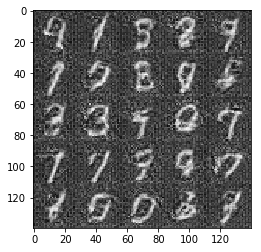

Epoch:  1 Batch:  1110 Discriminator_Loss:  0.0348977 Generator_Loss:  11.2718
Epoch:  1 Batch:  1120 Discriminator_Loss:  0.00278737 Generator_Loss:  8.08413
Epoch:  1 Batch:  1130 Discriminator_Loss:  0.00786453 Generator_Loss:  7.32797
Epoch:  1 Batch:  1140 Discriminator_Loss:  0.000603101 Generator_Loss:  9.94211
Epoch:  1 Batch:  1150 Discriminator_Loss:  3.83373 Generator_Loss:  0.0786003
Epoch:  1 Batch:  1160 Discriminator_Loss:  2.44616 Generator_Loss:  0.244784
Epoch:  1 Batch:  1170 Discriminator_Loss:  1.52135 Generator_Loss:  0.397799
Epoch:  1 Batch:  1180 Discriminator_Loss:  1.62639 Generator_Loss:  0.298026
Epoch:  1 Batch:  1190 Discriminator_Loss:  1.06772 Generator_Loss:  0.598178
Epoch:  1 Batch:  1200 Discriminator_Loss:  1.54287 Generator_Loss:  0.320392


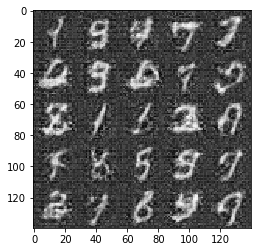

Epoch:  1 Batch:  1210 Discriminator_Loss:  1.38454 Generator_Loss:  0.481371
Epoch:  1 Batch:  1220 Discriminator_Loss:  1.93946 Generator_Loss:  0.224616
Epoch:  1 Batch:  1230 Discriminator_Loss:  0.886861 Generator_Loss:  0.73797
Epoch:  1 Batch:  1240 Discriminator_Loss:  0.444325 Generator_Loss:  1.32594
Epoch:  1 Batch:  1250 Discriminator_Loss:  0.858955 Generator_Loss:  0.831739
Epoch:  1 Batch:  1260 Discriminator_Loss:  0.477102 Generator_Loss:  1.3726
Epoch:  1 Batch:  1270 Discriminator_Loss:  1.15462 Generator_Loss:  0.487503
Epoch:  1 Batch:  1280 Discriminator_Loss:  0.722877 Generator_Loss:  0.945648
Epoch:  1 Batch:  1290 Discriminator_Loss:  1.8413 Generator_Loss:  0.292764
Epoch:  1 Batch:  1300 Discriminator_Loss:  0.461953 Generator_Loss:  1.23179


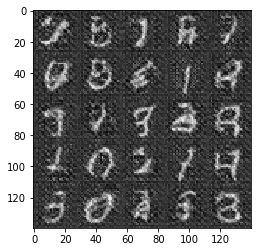

Epoch:  1 Batch:  1310 Discriminator_Loss:  0.171699 Generator_Loss:  2.39636
Epoch:  1 Batch:  1320 Discriminator_Loss:  0.24502 Generator_Loss:  1.97037
Epoch:  1 Batch:  1330 Discriminator_Loss:  0.067246 Generator_Loss:  3.45994
Epoch:  1 Batch:  1340 Discriminator_Loss:  0.044819 Generator_Loss:  4.15951
Epoch:  1 Batch:  1350 Discriminator_Loss:  0.0210695 Generator_Loss:  5.87037
Epoch:  1 Batch:  1360 Discriminator_Loss:  0.0229639 Generator_Loss:  5.29904
Epoch:  1 Batch:  1370 Discriminator_Loss:  0.0280708 Generator_Loss:  5.43144
Epoch:  1 Batch:  1380 Discriminator_Loss:  0.0240494 Generator_Loss:  4.61147
Epoch:  1 Batch:  1390 Discriminator_Loss:  0.0715258 Generator_Loss:  3.4186
Epoch:  1 Batch:  1400 Discriminator_Loss:  0.0174478 Generator_Loss:  5.27238


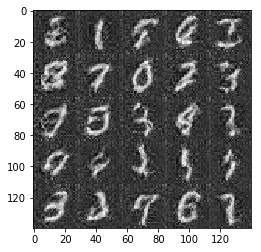

Epoch:  1 Batch:  1410 Discriminator_Loss:  0.00960284 Generator_Loss:  6.41449
Epoch:  1 Batch:  1420 Discriminator_Loss:  0.00770657 Generator_Loss:  7.4709
Epoch:  1 Batch:  1430 Discriminator_Loss:  0.0235271 Generator_Loss:  5.74671
Epoch:  1 Batch:  1440 Discriminator_Loss:  0.00575441 Generator_Loss:  8.98494
Epoch:  1 Batch:  1450 Discriminator_Loss:  5.7447 Generator_Loss:  0.00833049
Epoch:  1 Batch:  1460 Discriminator_Loss:  1.59842 Generator_Loss:  3.36951
Epoch:  1 Batch:  1470 Discriminator_Loss:  0.910956 Generator_Loss:  2.85113
Epoch:  1 Batch:  1480 Discriminator_Loss:  0.569956 Generator_Loss:  1.14491
Epoch:  1 Batch:  1490 Discriminator_Loss:  0.849059 Generator_Loss:  0.772321
Epoch:  1 Batch:  1500 Discriminator_Loss:  1.37935 Generator_Loss:  0.408735


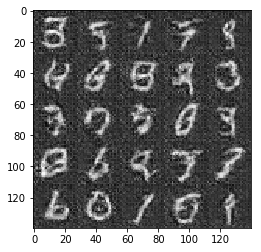

Epoch:  1 Batch:  1510 Discriminator_Loss:  1.72852 Generator_Loss:  0.298141
Epoch:  1 Batch:  1520 Discriminator_Loss:  2.01153 Generator_Loss:  0.231172
Epoch:  1 Batch:  1530 Discriminator_Loss:  0.722512 Generator_Loss:  0.904104
Epoch:  1 Batch:  1540 Discriminator_Loss:  1.69822 Generator_Loss:  0.294682
Epoch:  1 Batch:  1550 Discriminator_Loss:  0.771161 Generator_Loss:  0.893081
Epoch:  1 Batch:  1560 Discriminator_Loss:  2.1137 Generator_Loss:  0.204083
Epoch:  1 Batch:  1570 Discriminator_Loss:  1.86664 Generator_Loss:  0.300813
Epoch:  1 Batch:  1580 Discriminator_Loss:  0.593696 Generator_Loss:  1.17418
Epoch:  1 Batch:  1590 Discriminator_Loss:  2.80557 Generator_Loss:  7.63573
Epoch:  1 Batch:  1600 Discriminator_Loss:  0.464261 Generator_Loss:  1.8978


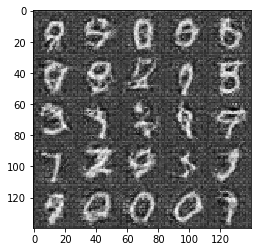

Epoch:  1 Batch:  1610 Discriminator_Loss:  1.22369 Generator_Loss:  4.07393
Epoch:  1 Batch:  1620 Discriminator_Loss:  0.438666 Generator_Loss:  1.53661
Epoch:  1 Batch:  1630 Discriminator_Loss:  0.944737 Generator_Loss:  0.6934
Epoch:  1 Batch:  1640 Discriminator_Loss:  1.03961 Generator_Loss:  0.726858
Epoch:  1 Batch:  1650 Discriminator_Loss:  0.687319 Generator_Loss:  1.18559
Epoch:  1 Batch:  1660 Discriminator_Loss:  1.122 Generator_Loss:  0.562528
Epoch:  1 Batch:  1670 Discriminator_Loss:  1.47464 Generator_Loss:  0.432515
Epoch:  1 Batch:  1680 Discriminator_Loss:  0.50042 Generator_Loss:  1.36253
Epoch:  1 Batch:  1690 Discriminator_Loss:  0.193362 Generator_Loss:  2.7216
Epoch:  1 Batch:  1700 Discriminator_Loss:  0.149252 Generator_Loss:  3.11186


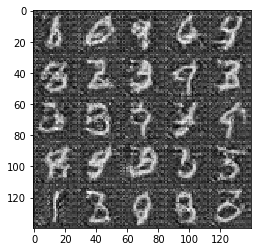

Epoch:  1 Batch:  1710 Discriminator_Loss:  0.201029 Generator_Loss:  4.1562
Epoch:  1 Batch:  1720 Discriminator_Loss:  0.413691 Generator_Loss:  1.94939
Epoch:  1 Batch:  1730 Discriminator_Loss:  0.46502 Generator_Loss:  1.49138
Epoch:  1 Batch:  1740 Discriminator_Loss:  0.324002 Generator_Loss:  1.88086
Epoch:  1 Batch:  1750 Discriminator_Loss:  0.167281 Generator_Loss:  2.40008
Epoch:  1 Batch:  1760 Discriminator_Loss:  0.0637656 Generator_Loss:  3.79516
Epoch:  1 Batch:  1770 Discriminator_Loss:  0.217853 Generator_Loss:  2.36847
Epoch:  1 Batch:  1780 Discriminator_Loss:  0.0823055 Generator_Loss:  3.54667
Epoch:  1 Batch:  1790 Discriminator_Loss:  0.0412879 Generator_Loss:  4.17448
Epoch:  1 Batch:  1800 Discriminator_Loss:  0.464612 Generator_Loss:  1.86714


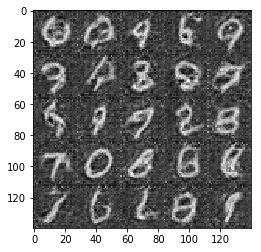

Epoch:  1 Batch:  1810 Discriminator_Loss:  0.383082 Generator_Loss:  1.66436
Epoch:  1 Batch:  1820 Discriminator_Loss:  0.377863 Generator_Loss:  1.71783
Epoch:  1 Batch:  1830 Discriminator_Loss:  0.159671 Generator_Loss:  2.85001
Epoch:  1 Batch:  1840 Discriminator_Loss:  0.138186 Generator_Loss:  2.81969
Epoch:  1 Batch:  1850 Discriminator_Loss:  0.0318222 Generator_Loss:  5.28027
Epoch:  1 Batch:  1860 Discriminator_Loss:  0.073782 Generator_Loss:  3.96577
Epoch:  1 Batch:  1870 Discriminator_Loss:  0.101688 Generator_Loss:  3.20771


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.01


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [13]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.